# **House Price Correlation Study**

## Objectives

* Perform data analysis to address business requirement 1:
The client is interested in discovering how the house attributes correlate with the sale price. Therefore, the client expects data visualisations of the correlated variables against the sale price to show that.

## Inputs

* Dataset: outputs/datasets/collection/HousePricesRecords.csv

## Outputs

* Code to address the business requirement above, which will be used in the final dashboard app.

## Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

# Change working directory

We need to change the working directory from its current folder to its parent folder
* We access the current directory with os.getcwd()

In [3]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing/jupyter_notebooks'

We want to make the parent of the current directory the new current directory
* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [4]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [5]:
current_dir = os.getcwd()
current_dir

'/workspace/heritage-housing'

# Load Data

Load the raw data and print the first three rows to check information.

In [6]:
import pandas as pd
df = (pd.read_csv("outputs/datasets/collection/HousePricesRecords.csv"))
df.head(3)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500


---

# Data Exploration

Check each variable to understand more information about the data set, by using Pandas profiling.

In [7]:
from pandas_profiling import ProfileReport
pandas_report = ProfileReport(df=df, minimal=True)
pandas_report.to_notebook_iframe()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Key points of note from profiling:
- The majority of variables are numerical.
- Many variables have missing data.
- The target (SalePrice) has a positive skewed distribution.

---

# Correlation Study

A combination of correlation and PPS (Predictive Power Score) will be used to analyse the data.

Some custom functions are defined below, with the following two being called:
- CalculateCorrAndPPS(): calculates the correlation tables and PPS table for a dataset, and prints the Q1 and Q3 for PPS scores.
- DisplayCorrAndPPS(): provides a visualisation of the correlation and PPS of the data.

Note: These custom functions have been taken from the Code Institute learning materials, from the lesson notebook "Predictive Power Score Unit 1".

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
%matplotlib inline

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=np.bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")
    print("* Analyse how the target variable for your ML models are correlated with other variables (features and target)")
    print("* Analyse multi-colinearity, that is, how the features are correlated among themselves")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)

Calling the CalculateCorrAndPPS fundction.

In [12]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:666: UserWarning: The least populated class in y has only 3 members, which is less than n_splits=4.
  warnings.warn(("The least populated class in y has only %d"
/workspa

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702


Calling the DisplayCorrAndPPS function. The correlation threshold has been set to 0.6, as over this value is deemed a strong correlation. THe PPS threshold has been set at 0.15 as a value over 0.2 is deemed to have strong predictive power.



* Analyse how the target variable for your ML models are correlated with other variables (features and target)
* Analyse multi-colinearity, that is, how the features are correlated among themselves


*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



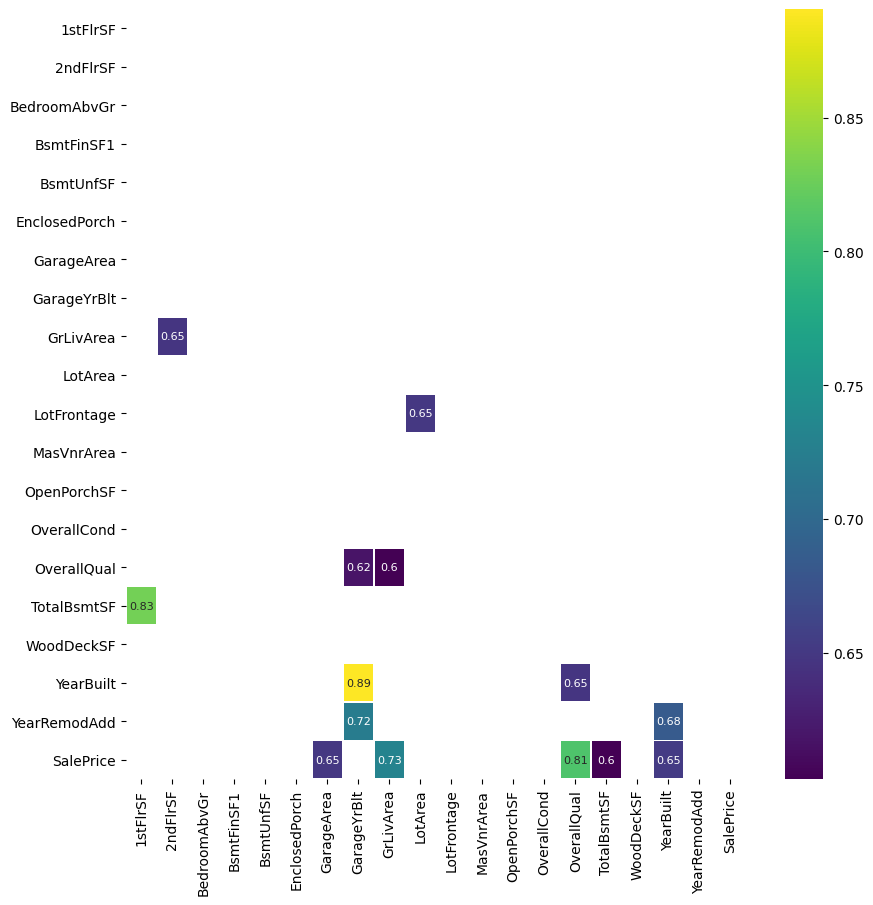



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



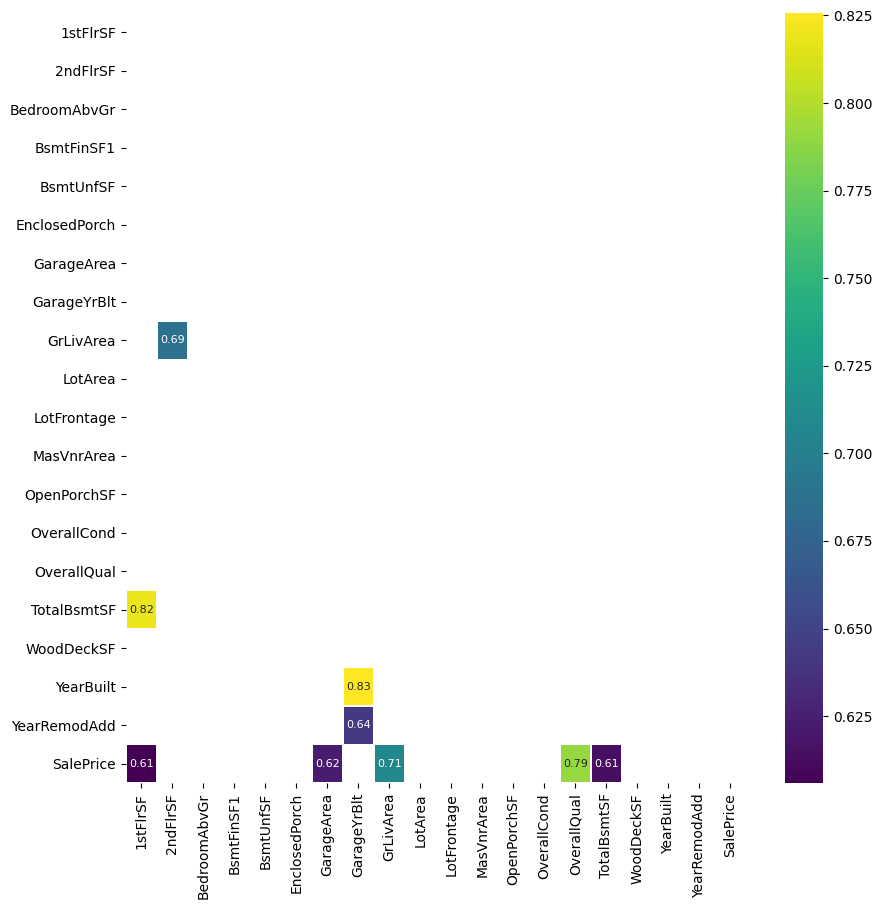



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



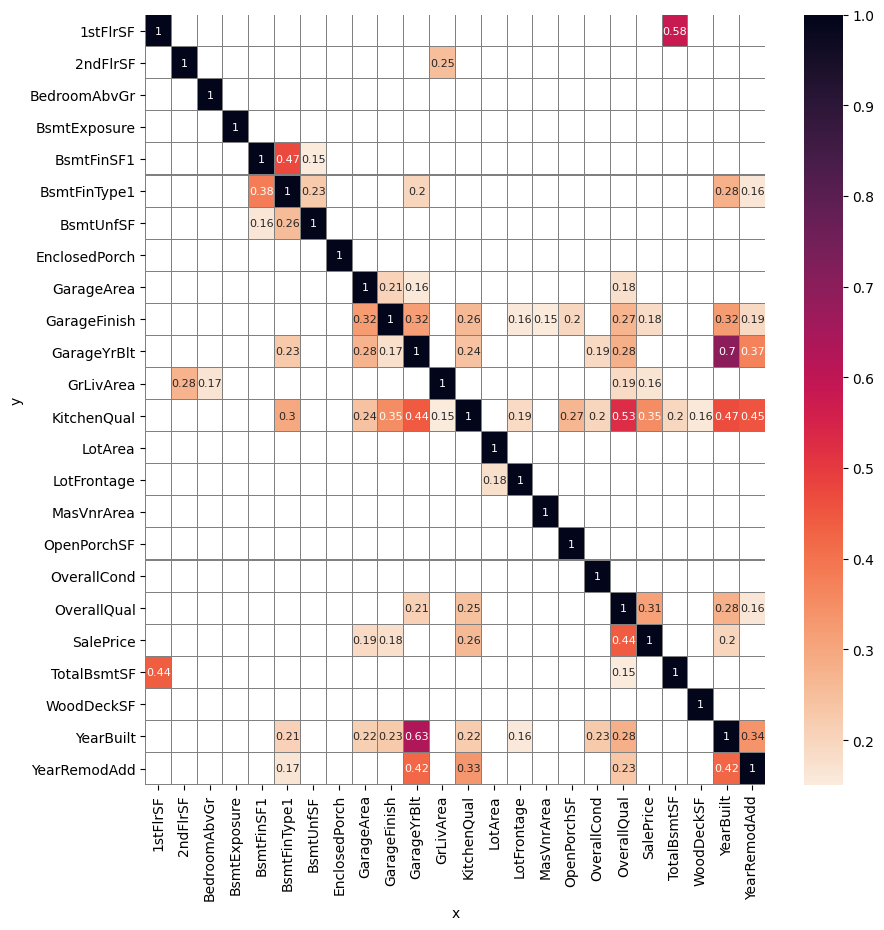

In [13]:
DisplayCorrAndPPS(df_corr_pearson=df_corr_pearson,
                  df_corr_spearman=df_corr_spearman, 
                  pps_matrix=pps_matrix,
                  CorrThreshold=0.6, PPS_Threshold=0.15,
                  figsize=(10,10), font_annot=8)

The client is interested in discovering how the house attributes correlate with the sale price. The key points of note from these visualisations in relation to Sales Price) are as follows:
- The Spearman correlation graph suggests that OverallQual, GrLivArea, GarageArea, YearBuilt and TotalBsmtSF have strong monotonic relationships with Sales Price (from highest to lowest).
- The Pearson correlation graph shows that OverallQual, GrLivArea, GarageArea, 1stFlrSF and TotalBsmtSF have strong linear relationships with Sales Price (from highest to lowest).
- A PPS over 0.2 is generally indicative of strong predictive power. This chart suggests the OverallQual and KitchenQual have strong predictive power for Sales Price, with GarageArea and GarageFinish having some (but weak) predictive power.

Based on this information, the following variables will be considered: OverallQual, GrLivArea, GarageArea, YearBuilt, 1stFlrSF, TotalBsmtSF and KitchenQual. These have been included into the below variable.


In [14]:
vars_to_study = ['OverallQual', 'GrLivArea', 'GarageArea', 'YearBuilt', '1stFlrSF', 'TotalBsmtSF', 'KitchenQual']
vars_to_study

['OverallQual',
 'GrLivArea',
 'GarageArea',
 'YearBuilt',
 '1stFlrSF',
 'TotalBsmtSF',
 'KitchenQual']

A dataframe for data study with just these variables, plus the target (SalePrice), is created below:

In [15]:
df_study = df.filter(vars_to_study + ['SalePrice'])
df_study

,OverallQual,GrLivArea,GarageArea,YearBuilt,1stFlrSF,TotalBsmtSF,KitchenQual,SalePrice
0,7,1710,548,2003,856,856,Gd,208500
1,6,1262,460,1976,1262,1262,TA,181500
2,7,1786,608,2001,920,920,Gd,223500
3,7,1717,642,1915,961,756,Gd,140000
4,8,2198,836,2000,1145,1145,Gd,250000
...,...,...,...,...,...,...,...,...
1455,6,1647,460,1999,953,953,TA,175000
1456,6,2073,500,1978,2073,1542,TA,210000
1457,7,2340,252,1941,1188,1152,Gd,266500
1458,5,1078,240,1950,1078,1078,Gd,142125


The following custom functions will plot each selected variable against the target SalePrice, as scatterplots.
This code has been adapted from the Code Institute Churnometer Walkthrough Project.

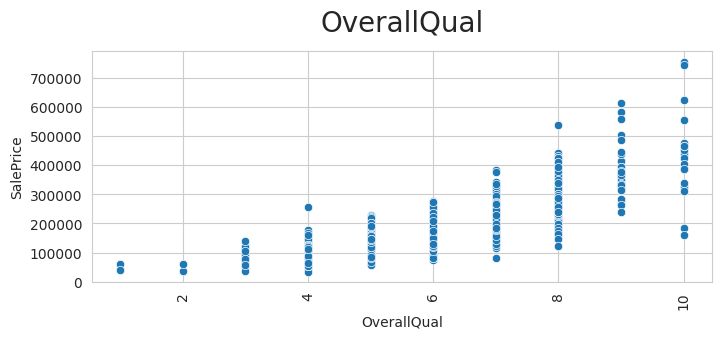

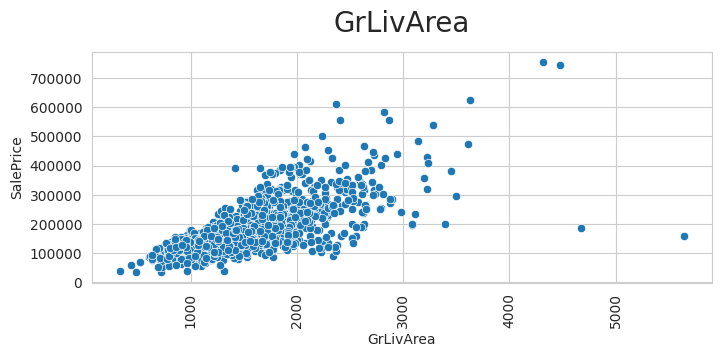

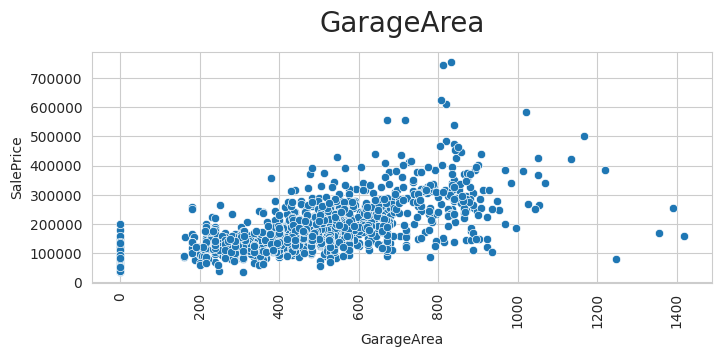

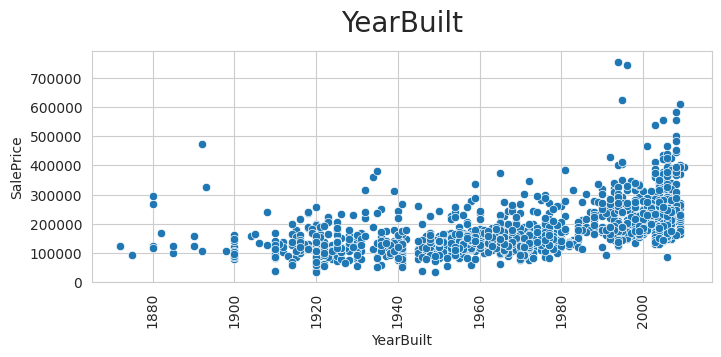

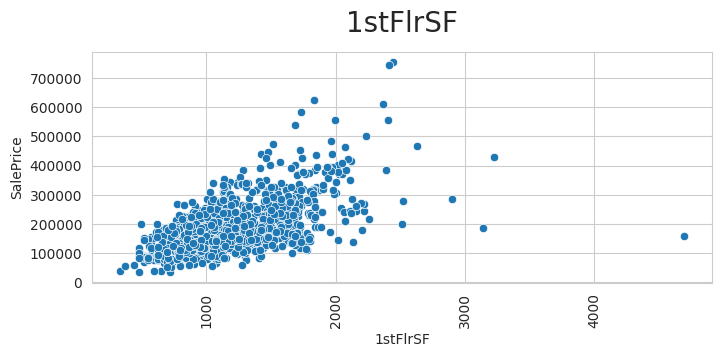

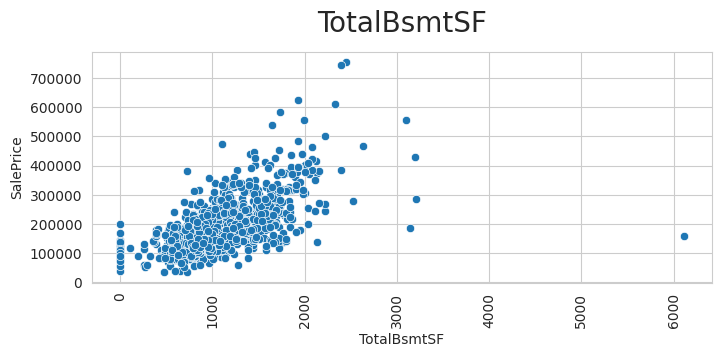

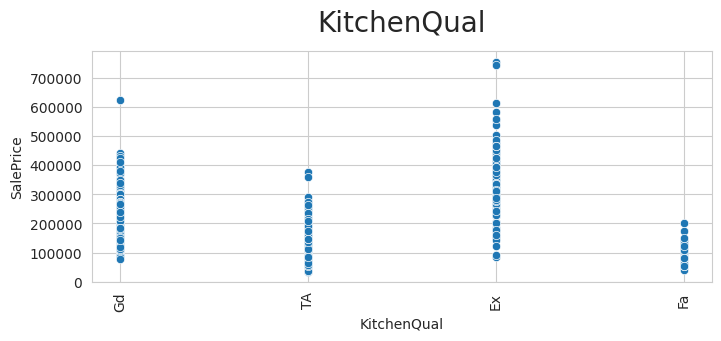

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')


def plot_scatter(df, col, target_var):

    plt.figure(figsize=(8, 3))
    sns.scatterplot(data=df, x=col, y=target_var)
    plt.xticks(rotation=90)
    plt.title(f"{col}", fontsize=20, y=1.05)
    plt.show()


target_var = 'SalePrice'
for col in vars_to_study:
    plot_scatter(df_study, col, target_var)
    print("\n\n")

---

# Conclusions

From analysing the scatter graphs above, along with the correlation and PPS analysis, the following key conclusions can be obtained:
- Houses with higher overall quality score (i.e. higher quality material and finish) and quality of kitchen tend to have a higher sales price.
- Larger houses (i.e. with higher above ground living area, 1st floor area, basement area and (to a lesser extent) garage area) tend to sell for a higher price.
- Newer houses (i.e. those built more recently) will generally sell for a higher price, although the correlation is weaker than for the above attributes.

This provides the conclusions to the first business requirement: "The client is interested in discovering how the house attributes correlate with the sale price". These visualisations will be included in the dashboard.


---

# Next Steps

The next step is to start work addressing the second business requirement: "The client is interested in predicting the house sale price from her four inherited houses and any other house in Ames, Iowa".